In [1]:
pip install regex

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install morfeusz2

Note: you may need to restart the kernel to use updated packages.


In [83]:
import re
import tarfile
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from morfeusz2 import Morfeusz

# 1. For each bill compute the number of the following amendments present in the bill:
- addition of a unit (e.g. dodaje się ust. 5a),
- removal of a unit (e.g. w art. 10 ust. 1 pkt 8 skreśla się),
- change of a unit (e.g. art. 5 otrzymuje brzmienie).

In [2]:
os.getcwd()

'C:\\Users\\jpasi\\PJN'

In [3]:
if len(glob.glob("*.txt")) == 0:
    bills = tarfile.open("ustawy.tar.gz", "r:gz")
    bills.extractall()
    bills.close()

In [5]:
bills_list = []
additions, removals, changes = {}, {}, {}

addition_regex = "dodaje\s+się\s+(art\.|ust\.|pkt)\s*\d+\w?"
removal_regex = "skreśla\s+się\W+(art\.|ust\.|pkt)\s*\d+\w?"
change_regex = "(art\.|ust\.|pkt)\s*\d+\w?.*\sotrzymuj\D\s(brzmienie|oznaczenie)"

regexes = [addition_regex, removal_regex, change_regex]
amendments = [additions, removals, changes]

for file in glob.glob("*.txt"):
    bills_list += file
    with open(os.getcwd() + "/" + file, 'r', encoding='utf-8') as f:
        bill = f.read()
        year = int(file[:4])
        for amendment, regex in zip(amendments, regexes):
            found_regex = re.findall(regex, bill)
            if year in amendment.keys():
                amendment[year] += len(found_regex)
            else:
                amendment[year] = len(found_regex) 
        

In [9]:
data = {"addition": amendments[0],
             "removal": amendments[1],
             "change": amendments[2]}
amendments_df = pd.DataFrame(data)

In [10]:
amendments_df

,addition,removal,change
1993,32,4,63
1994,92,28,158
1995,315,79,378
1996,464,195,902
1997,636,266,1074
1998,201,79,302
1999,155,55,183
2000,740,306,1530
2001,1020,236,1393
2002,89,1,199


In [31]:
amendments_df["sum"] = amendments_df.sum(axis=1)

In [33]:
amendments_pct_df = amendments_df.loc[:, "addition":"change"].div(amendments_df["sum"], axis=0)

<AxesSubplot:title={'center':'Percentage of different amendment types in polish law by year'}, xlabel='Year'>

<Figure size 432x288 with 0 Axes>

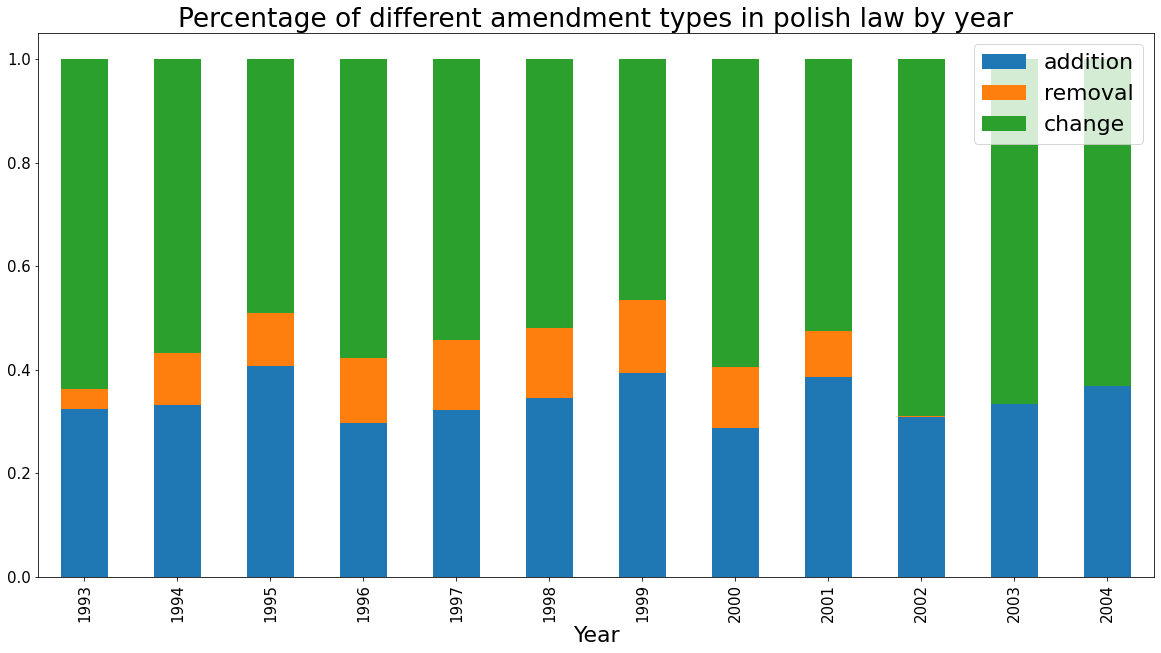

In [43]:
plt.figure()
plt.rcParams.update({'font.size': 22})
amendments_pct_df.plot.bar(stacked=True, figsize=(20, 10), title="Percentage of different amendment types in polish law by year", xlabel="Year", fontsize=15)

# 2. Compute the total number of occurrences of the word ustawa in any inflectional form (ustawa, ustawie, ustawę, etc.) and all spelling forms (ustawa, Ustawa, USTAWA), excluding other words with the same prefix (e.g. ustawić).

In [45]:
morf = Morfeusz()
forms = morf.generate("ustawa")

In [46]:
forms

[('ustawa', 'ustawa', 'subst:sg:nom:f', ['nazwa_pospolita'], []),
 ('ustawy', 'ustawa', 'subst:sg:gen:f', ['nazwa_pospolita'], []),
 ('ustawie', 'ustawa', 'subst:sg:dat.loc:f', ['nazwa_pospolita'], []),
 ('ustawę', 'ustawa', 'subst:sg:acc:f', ['nazwa_pospolita'], []),
 ('ustawą', 'ustawa', 'subst:sg:inst:f', ['nazwa_pospolita'], []),
 ('ustawo', 'ustawa', 'subst:sg:voc:f', ['nazwa_pospolita'], []),
 ('ustawy', 'ustawa', 'subst:pl:nom.acc.voc:f', ['nazwa_pospolita'], []),
 ('ustaw', 'ustawa', 'subst:pl:gen:f', ['nazwa_pospolita'], []),
 ('ustawom', 'ustawa', 'subst:pl:dat:f', ['nazwa_pospolita'], []),
 ('ustawami', 'ustawa', 'subst:pl:inst:f', ['nazwa_pospolita'], []),
 ('ustawach', 'ustawa', 'subst:pl:loc:f', ['nazwa_pospolita'], []),
 ('U', 'ustawa', 'brev:pun', [], [])]

In [74]:
ustawa_regex = r'\b('
for i, form in zip(range(1, 12), forms):
    if i < 11:
        ustawa_regex += str(form[0])
        ustawa_regex += "|"
    if i==11:
        ustawa_regex += str(form[0])
        ustawa_regex += ")"

In [75]:
ustawa_regex

'\\b(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)'

In [138]:
z_dnia_expression = ustawa_regex+ "\W+z dnia"
wo_z_dnia_expression = ustawa_regex + "\W+(?!z dnia)"
wo_o_zmianie_expression = ustawa_regex + "\W+(?!o zmianie)"

In [139]:
z_dnia_expression

'\\b(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)\\W+z dnia'

In [140]:
ustawa_regexes = [ustawa_regex, z_dnia_expression, wo_z_dnia_expression, wo_o_zmianie_expression]
counts = [{}, {}, {}, {}]

In [141]:
for file in glob.glob("*.txt"):
    with open(os.getcwd() + "/" + file, 'r', encoding='utf-8') as f:
        bill = f.read().lower()
        for index, reg in enumerate(ustawa_regexes):
            found = re.findall(reg, bill)
            counts[index] = dict(Counter(counts[index]) + Counter(found))

In [142]:
totals = []
for count in counts:
    total = 0
    for value in count.values():
        total += value
    totals += [total]

In [143]:
totals

[25759, 8105, 17739, 24903]

In [144]:
data2 = {"Ustawa": totals[0],
             "With 'z dnia'": totals[1],
             "Without 'z dnia'": totals[2],
            "Without 'o zmianie'": totals[3]}

In [145]:
print(totals[1] + totals[2])

25844


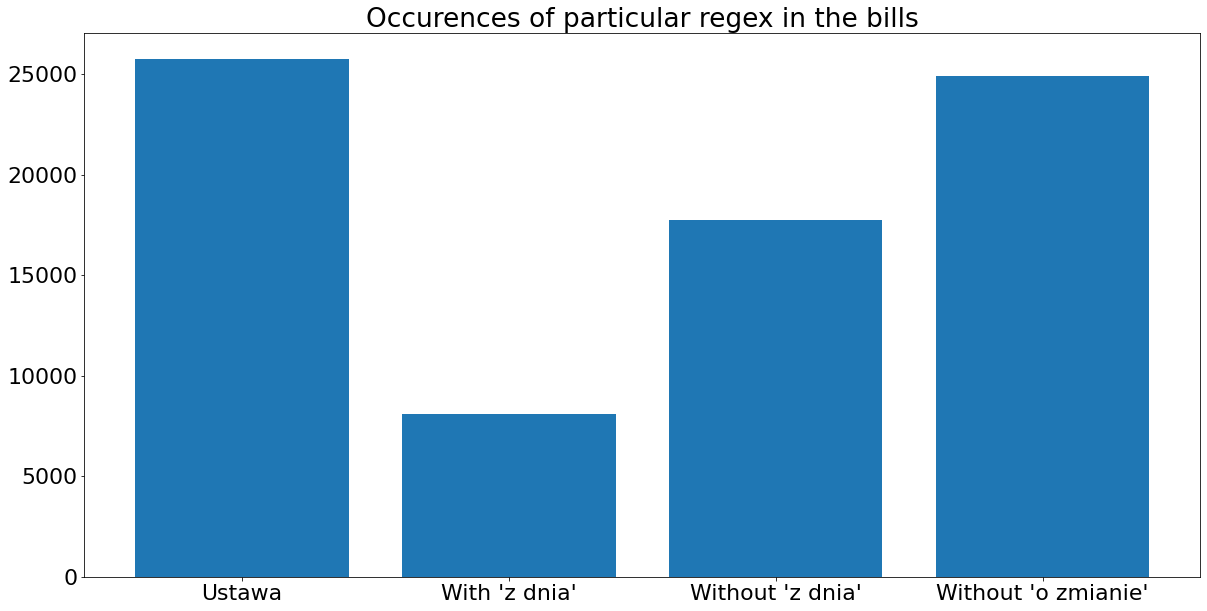

In [146]:
plt.figure(figsize=(20, 10))
plt.title("Occurences of particular regex in the bills")
plt.bar(*zip(*data2.items()))
plt.show()